In [15]:
!pip install xgboost imbalanced-learn


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib


In [17]:
df = pd.read_csv("/content/fraud_data/card_transdata.csv")
df.head()


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [18]:
df.shape
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


,0
distance_from_home,0
distance_from_last_transaction,0
ratio_to_median_purchase_price,0
repeat_retailer,0
used_chip,0
used_pin_number,0
online_order,0
fraud,0


In [19]:
df['fraud'].value_counts(), df['fraud'].value_counts(normalize=True) * 100


(fraud
 0.0    912597
 1.0     87403
 Name: count, dtype: int64,
 fraud
 0.0    91.2597
 1.0     8.7403
 Name: proportion, dtype: float64)

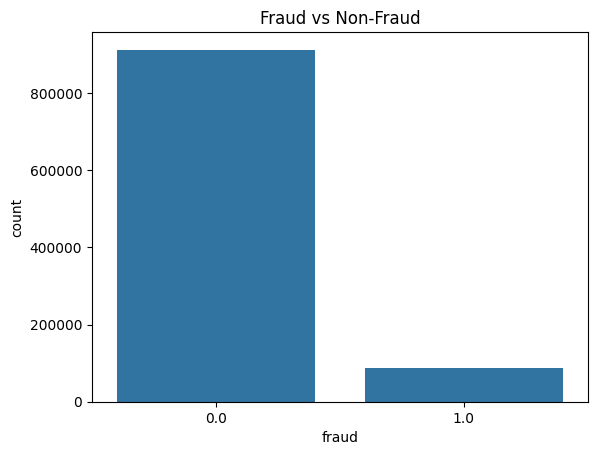

In [20]:
sns.countplot(x='fraud', data=df)
plt.title("Fraud vs Non-Fraud")
plt.show()


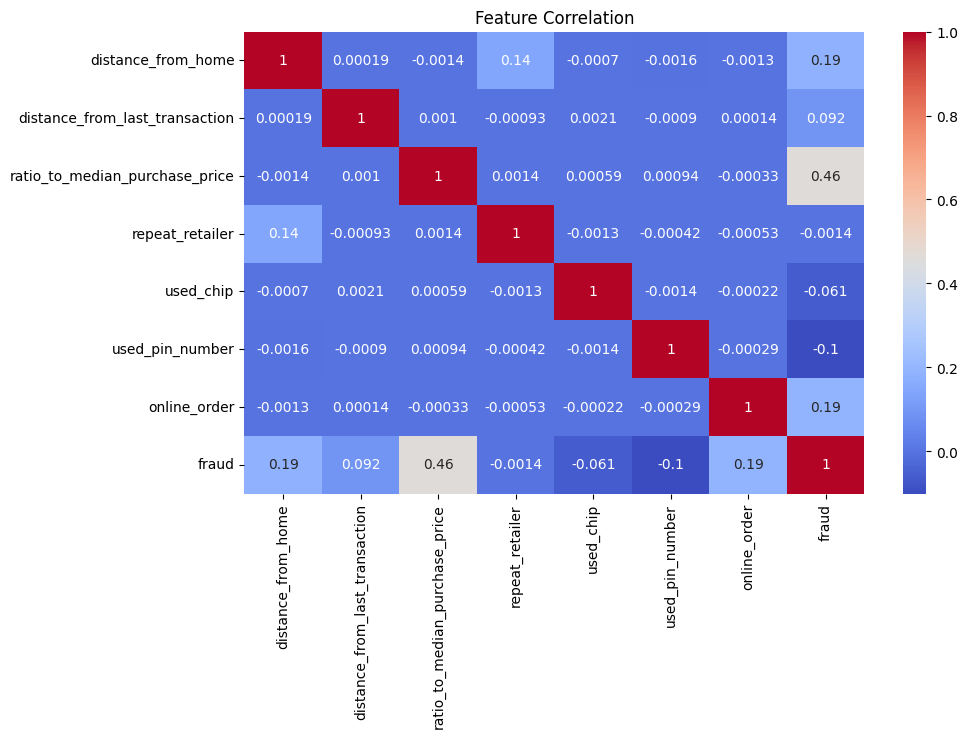

In [24]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()


In [21]:
from sklearn.model_selection import train_test_split

X = df.drop("fraud", axis=1)
y = df["fraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [22]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [23]:
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: fraud
0.0    684448
1.0     65552
Name: count, dtype: int64
After SMOTE: fraud
0.0    684448
1.0    684448
Name: count, dtype: int64


In [25]:
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train_res, y_train_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

Accuracy: 0.997444
Precision: 0.973228627520971
Recall: 0.998215184659741
F1 Score: 0.9855635632469557

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    228149
         1.0       0.97      1.00      0.99     21851

    accuracy                           1.00    250000
   macro avg       0.99      1.00      0.99    250000
weighted avg       1.00      1.00      1.00    250000



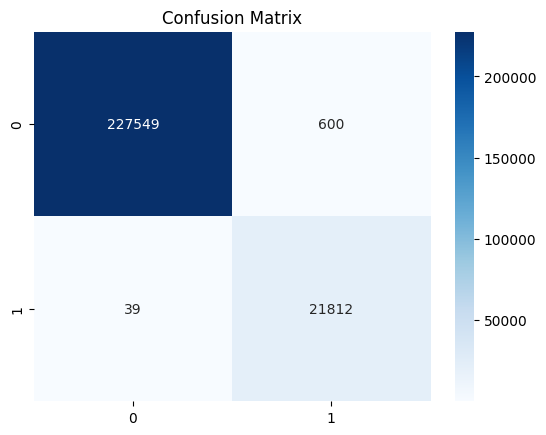

In [26]:
y_pred = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))    # most important
print("F1 Score:", f1_score(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


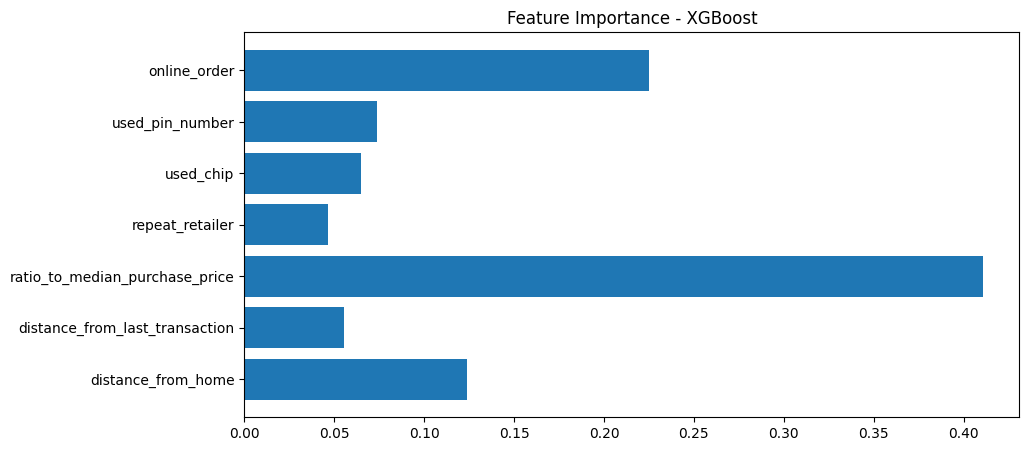

In [27]:
plt.figure(figsize=(10,5))
plt.barh(X.columns, xgb_model.feature_importances_)
plt.title("Feature Importance - XGBoost")
plt.show()


In [28]:
joblib.dump(xgb_model, "/content/xgboost_fraud_model.pkl")


['/content/xgboost_fraud_model.pkl']

In [29]:
sample_transaction = [[
    50,     # distance_from_home
    1,      # distance_from_last_transaction
    1.8,    # ratio_to_median_purchase_price
    1,      # repeat_retailer
    1,      # used_chip
    0,      # used_pin_number
    1       # online_order
]]

prediction = xgb_model.predict(sample_transaction)
print("Fraud?" , "YES" if prediction[0] == 1 else "NO")


Fraud? NO


In [30]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_res, y_train_res)


KeyboardInterrupt: 

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=120,        # Reduced from 300
    max_depth=8,             # Lower depth speeds up training
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1                # Use all CPU cores
)

rf_model.fit(X_train_res, y_train_res)


KeyboardInterrupt: 

In [32]:
from sklearn.ensemble import ExtraTreesClassifier

rf_model = ExtraTreesClassifier(
    n_estimators=120,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_res, y_train_res)


ExtraTreesClassifier(max_depth=8, n_estimators=120, n_jobs=-1, random_state=42)

In [33]:
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]


In [34]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("📌 RANDOM FOREST CLASSIFICATION REPORT")
print(classification_report(y_test, rf_pred))

print("📌 CONFUSION MATRIX")
print(confusion_matrix(y_test, rf_pred))

print("📌 ROC-AUC SCORE")
print(roc_auc_score(y_test, rf_proba))


📌 RANDOM FOREST CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.99      0.63      0.77    228149
         1.0       0.20      0.95      0.33     21851

    accuracy                           0.66    250000
   macro avg       0.59      0.79      0.55    250000
weighted avg       0.92      0.66      0.73    250000

📌 CONFUSION MATRIX
[[143158  84991]
 [  1102  20749]]
📌 ROC-AUC SCORE
0.8917883208357743


In [35]:
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]


In [36]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

comparison = pd.DataFrame({
    "Model": ["XGBoost", "Random Forest"],
    "Precision": [
        precision_score(y_test, xgb_pred),
        precision_score(y_test, rf_pred)
    ],
    "Recall": [
        recall_score(y_test, xgb_pred),
        recall_score(y_test, rf_pred)
    ],
    "F1-Score": [
        f1_score(y_test, xgb_pred),
        f1_score(y_test, rf_pred)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, xgb_proba),
        roc_auc_score(y_test, rf_proba)
    ]
})

comparison


,Model,Precision,Recall,F1-Score,ROC-AUC
0,XGBoost,0.973229,0.998215,0.985564,0.999980
1,Random Forest,0.196227,0.949568,0.325242,0.891788


<Figure size 700x500 with 0 Axes>

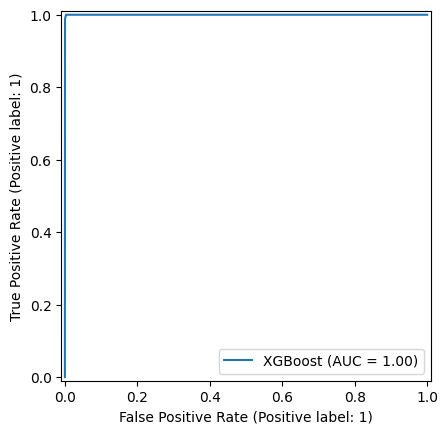

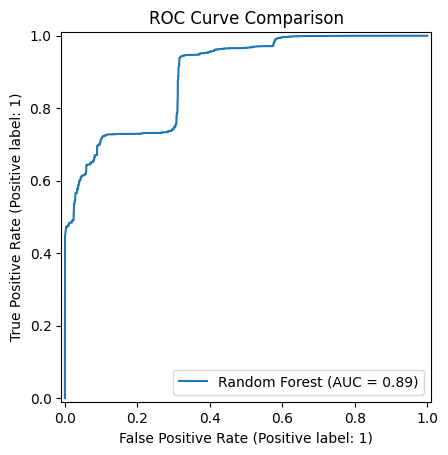

In [37]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
RocCurveDisplay.from_predictions(y_test, xgb_proba, name="XGBoost")
RocCurveDisplay.from_predictions(y_test, rf_proba, name="Random Forest")
plt.title("ROC Curve Comparison")
plt.show()
